# Rolling window

# ==================

### Peaks
### Valleys
### Window size

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [50]:

def rolling_window(financial_data: pd.DataFrame, record_to_plot: int = None, half_window_size: int = 5, peak_coeff=0.5, valley_coeff=0.5, to_plot: bool = False):
    financial_data = financial_data[:record_to_plot]
    financial_data['signal'] = 0

    data = financial_data['Close'].to_numpy()
    pltly_fig = go.Figure()
   
    def is_local_valley(data, current_index, half_window_size, threshold_coefficient):
        if current_index < half_window_size or current_index >= len(data) - half_window_size:
            return False

        neighborhood = data[current_index - half_window_size : current_index + half_window_size + 1]

        min_value = np.min(neighborhood)
        max_value = np.max(neighborhood)
        threshold = min_value + threshold_coefficient * (max_value - min_value)

        return data[current_index] <= threshold

    def is_local_peak(data, current_index, half_window_size, threshold_coefficient):
        if current_index < half_window_size or current_index >= len(data) - half_window_size:
            return False

        neighborhood = data[current_index - half_window_size : current_index + half_window_size + 1]

        min_value = np.min(neighborhood)
        max_value = np.max(neighborhood)
        threshold = threshold_coefficient * (max_value - min_value) + min_value

        # Function is similar to valleys, but with the inequality reversed
        return data[current_index] >= threshold


    # Detect peaks: The value at the current index is greater than or equal to the threshold value
    peaks_indices = [i for i in range(half_window_size, len(data) - half_window_size) if is_local_peak(data, i, half_window_size, peak_coeff)]

    # Detect valleys: The value at the current index is less than or equal to the threshold value
    valleys_indices = [i for i in range(half_window_size, len(data) - half_window_size) if is_local_valley(data, i, half_window_size, valley_coeff)]

    # Store the index of financial data
    index = financial_data.index

    # Initialize the last signal
    last_signal = 0
    
    # Loop through each index in the 'financial_data' DataFrame
    for i in range(len(financial_data)):
        # Set the 'signal' column value to 0 for the current index
        financial_data.loc[i, 'signal'] = 0

        # Check if the current index is a detected peak
        for peak in peaks_indices:
            if i == peak:
                if last_signal != 1:
                    #plt.scatter(index[i], financial_data['Low'][i],
                                #c='red', label='Sell', linewidth=1)
                   
                  
                  
                    pltly_fig.add_trace(go.Scatter(x=[index[i]], y=[financial_data['Low'][i]], mode='markers', name='Sell', marker=dict(color='lime'))) 
                  
                    last_signal = 1
                    financial_data.loc[i, 'signal'] = 1

        # Check if the current index is a detected valley
        for valley in valleys_indices:
            if i == valley:
                if last_signal != 2:
                    #plt.scatter(index[i], financial_data['Low'][i],
                                #c='lime', label='Buy', linewidth=1)

                    pltly_fig.add_trace(go.Scatter(x=[index[i]], y=[financial_data['Low'][i]], mode='markers', name='Buy', marker=dict(color='red')))
                    
                    last_signal = 2
                    financial_data.loc[i, 'signal'] = 2

    if to_plot:
        #plt.figure(figsize=(16, 8))
        pltly_fig.add_trace(go.Scatter(x=index, y=financial_data['Close'], mode='lines', name='Close',line_color='blue'))
        pltly_fig.update_layout(title='Rolling Window', xaxis_title='Date', yaxis_title='Price')
        pltly_fig.show()

        

    return financial_data


In [51]:
financial_data = pd.read_csv(
    "..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass


In [52]:
financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)


financial_data = financial_data.reset_index(drop=True)

## Experiment with trying to find the best combination of coefficients for a rolling window

```
highest_score = {
    "Equity Final [$]": 0,
    "peak_coeff": 0,
    "valley_coeff": 0
    
}
for j in range(1,10):
    for i in range(1,10):
        financial_data = rolling_window(financial_data, record_to_plot=1000, peak_coeff=j/10, valley_coeff=i/10, to_plot=False)
        bt,stats = backtester(financial_data)
        if stats["Equity Final [$]"] > highest_score["Equity Final [$]"]:
            highest_score = stats
            highest_score["peak_coeff"] = j/10
            highest_score["valley_coeff"] = i/10
                
    print(highest_score)
    
```

highest_score = {
    "Equity Final [$]":  12141.7
    "peak_coeff": 0.6,
    "valley_coeff": 0.3
     }


In [53]:
from apply_backtesting import backtester

financial_data = rolling_window(financial_data, record_to_plot=1000,half_window_size=30,peak_coeff=0.6, valley_coeff=0.3, to_plot=True)
bt,stats = backtester(financial_data)

C:\Users\bobek\AppData\Local\Temp\ipykernel_4084\2201326873.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



c:\Users\bobek\QuantWiseAI\jupiter_notebooks\apply_backtesting.py:36: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



In [54]:
#visualize the backtesting

import backtesting

# import output_notebook
from bokeh.io import output_notebook
output_notebook()

backtesting.set_bokeh_output(notebook=True)
bt.plot()

Loading BokehJS ...

c:\Python3_11_6_64bit\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

c:\Python3_11_6_64bit\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p3287', ...)

11997.791709999992


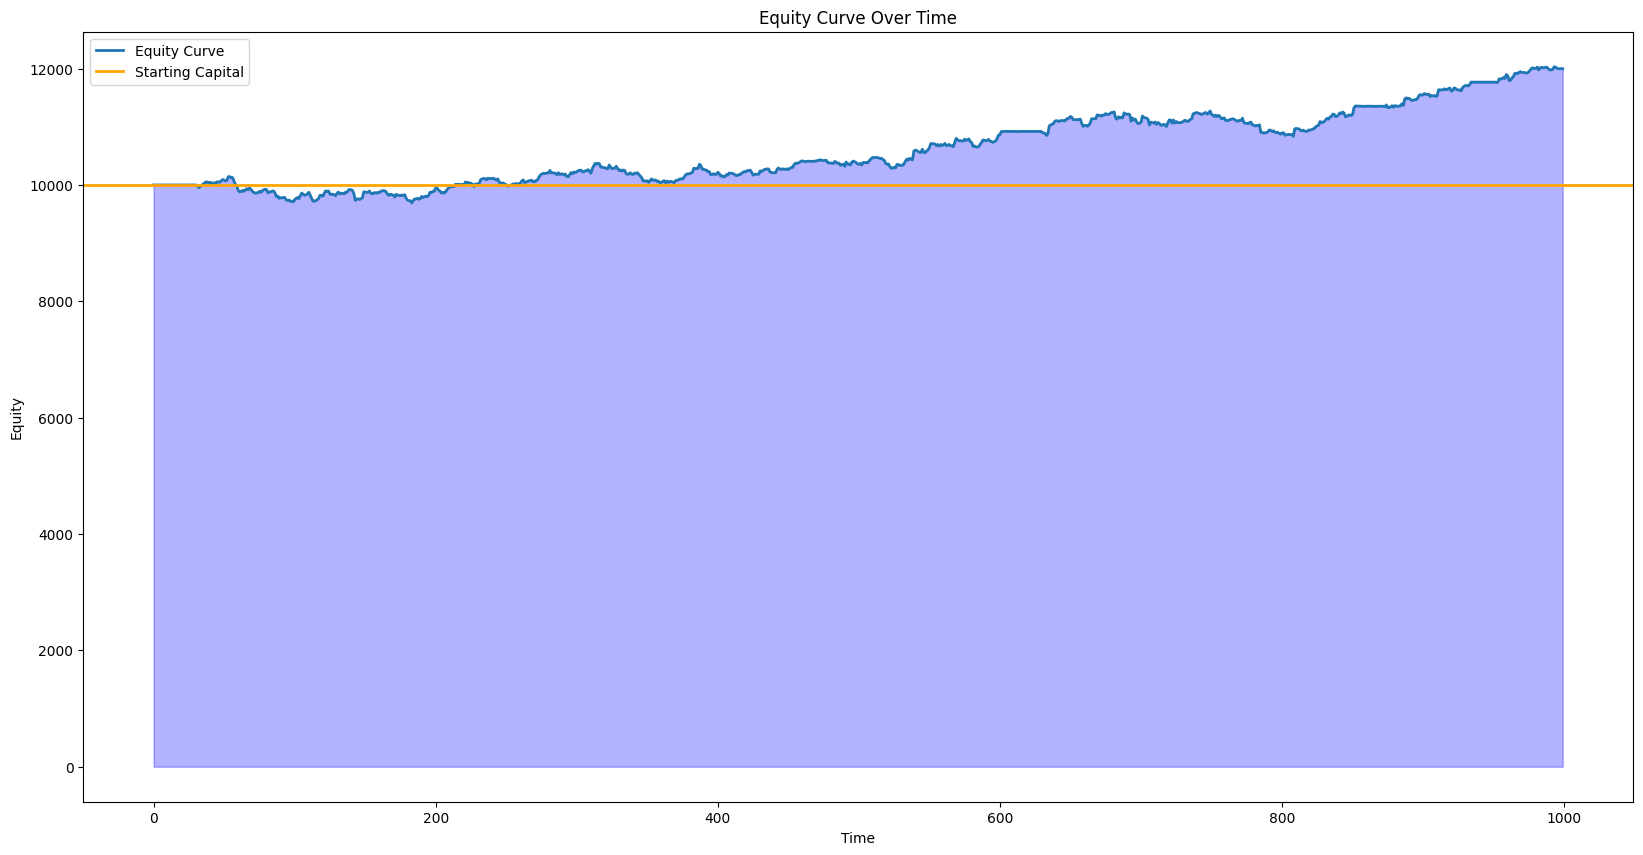

Equity Final [$]: 11997.791709999992


In [55]:

total_money_earned = stats
t = stats.T
print(t["Equity Final [$]"])
equity_curve = [i[0] for i in t._equity_curve.to_numpy()]

equity_curve = equity_curve[:1000]
equity_curve = np.array(equity_curve)


# Limit the number of data points to the first 1000
equity_curve = equity_curve[:1000]

# Plot the equity curve
plt.figure(figsize=(20, 10))
plt.plot(equity_curve, label='Equity Curve', linewidth=2)

# Fill the area between the equity curve and the x-axis
plt.fill_between(range(len(equity_curve)), equity_curve,
                 0, alpha=0.3, color='blue')

# Add labels and legend
plt.axhline(y=10000, color='orange', linestyle='-',
            label='Starting Capital', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity Curve Over Time')
plt.legend()

plt.show()

# Print the final equity
print(f'Equity Final [$]: {equity_curve[-1]}')


## Results

- Return: 20%
- Buy & Hold Return: 10.6%
- Win Rate: 90%


In [56]:
print(stats)

Start                                     0.0
End                                     999.0
Duration                                999.0
Exposure Time [%]                        95.2
Equity Final [$]                  11997.79171
Equity Peak [$]                   12032.43895
Return [%]                          19.977917
Buy & Hold Return [%]               10.624009
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.453707
Avg. Drawdown [%]                   -0.602167
Max. Drawdown Duration                  221.0
Avg. Drawdown Duration              17.384615
# Trades                                 21.0
Win Rate [%]                         90.47619
Best Trade [%]                       4.536437
Worst Trade [%]                     -0.534843
Avg. Trade [%]                    